In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
plt.style.use("Solarize_Light2")
%matplotlib inline
from DA_PoC.filters.ETKFQ import ETKFQ
from DA_PoC.dynamicalsystems.lorenz93 import Lorenz93Model

/mnt/c/Users/a846735/DA_sandbox/notebooks/../DA_PoC/filters/ETKFQ.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Model definition and example of forward model
We import the Lorenz93Model class, set its dimension (as a class variable)

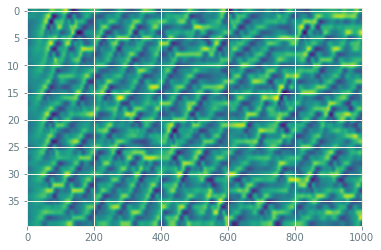

In [2]:
# Set class variable
state_dimension = 40
Lorenz93Model.dim = state_dimension
lorenz40 = Lorenz93Model()
x0 = np.random.normal(0, 1, lorenz40.dim)
lorenz40.set_initial_state(0, x0)
lorenz40.forward(1000)
plt.imshow(lorenz40.state_vector, aspect="auto")
plt.show()

## Truth definition
We introduce the "truth", which is a Lorenz93Model, with specified initial condition. We use a burn-in period of 1000 timesteps

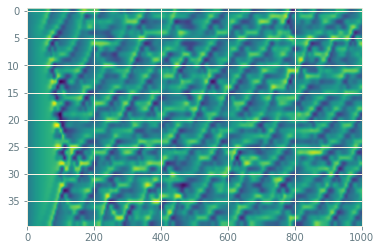

In [3]:
truth = Lorenz93Model()
x0 = np.zeros(state_dimension)
x0[0] = 1
truth.set_initial_state(-1000 * truth.dt, x0)
truth.forward(1000)
plt.imshow(truth.state_vector, aspect="auto")
plt.show()

We define a function to generate a projector,  observation operator $H$:


In [4]:
def create_projector(n: int, m: int, indices) -> np.ndarray:
    """Create a projector from a space of n dimension to m, where the identity is applied to the indices 

    :param n: input dimension
    :type n: int
    :param m: output dimension
    :type m: int
    :param indices: indices to keep
    :type indices: Iterable
    :return: Projection matrix
    :rtype: np.ndarray
    """    
    H = np.zeros((m, n))
    for i in indices:
        H[i, i] = 1
    return H

In [5]:
period_assim = 2
sigobs = 3
Nensemble = 32
dim_observations = 20 #state_dimension // 2
H = create_projector(state_dimension, dim_observations, np.arange(dim_observations))
R = sigobs * np.eye(dim_observations)
inflation_factor=1.05
sigma_model = 0.5
Q = np.eye(state_dimension) * sigma_model**2

In [6]:
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(state_dimension) * sigobs
    return truth.t[-1], y


In [7]:
etkf = ETKFQ(state_dimension, Nensemble, R, Q, inflation_factor)
etkf.set_forwardmodel(lambda x: Lorenz93Model.integrate(0, x, period_assim,)[1][:, -1] + np.random.multivariate_normal(np.zeros(state_dimension), cov=Q))
etkf.H = H
etkf.R = R #TODO verify how to call properly the setter at the __init__
siginit = 0.1
initial_state = truth.state_vector[:, -1]
covariance = siginit * np.eye(state_dimension)
etkf.generate_ensemble(mean=initial_state, cov=covariance)


In [8]:
Nsteps = 800
dETKF = etkf.run(Nsteps, generate_observations)

  0%|          | 0/800 [00:00<?, ?it/s]

self.U.shape=(32, 32)
m=32
truncated_eigvals=array([1.92956044, 1.60689135, 1.44596936, 1.28815009, 1.1694197 ,
       1.08509722, 1.07080261, 0.98012028, 0.93772872, 0.86747039,
       0.81447616, 0.76734196, 0.73681795, 0.63406417, 0.62350248,
       0.57368868, 0.519306  , 0.50484608, 0.4967076 , 0.4420972 ,
       0.42582157, 0.38814979, 0.37437234, 0.35881958, 0.34973044,
       0.32136284, 0.3192023 , 0.28871401, 0.27518518, 0.26050721,
       0.25512007])
self.U.shape=(32, 32)
m=32
truncated_eigvals=array([6.0659594 , 2.89488075, 2.40110653, 2.18221895, 2.10122732,
       1.8923338 , 1.76847718, 1.66661112, 1.58264176, 1.53897708,
       1.38173844, 1.27999519, 1.21688258, 1.08443019, 1.0556326 ,
       1.01006181, 0.97503638, 0.9098656 , 0.87711912, 0.78354048,
       0.77095552, 0.70867238, 0.62611831, 0.61764141, 0.52112871,
       0.48220068, 0.46202283, 0.37285133, 0.32716378, 0.3034346 ,
       0.29239517])
self.U.shape=(32, 32)
m=32
truncated_eigvals=array([6.30305961, 4.

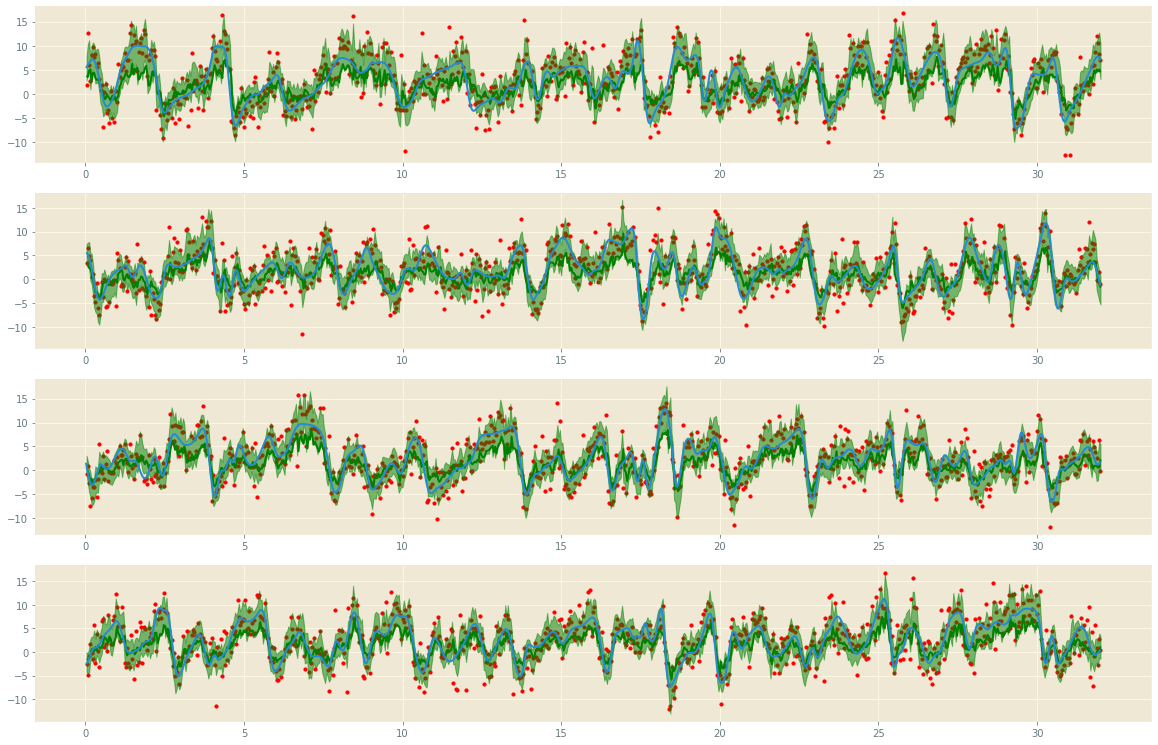

In [9]:
obs = np.array(dETKF["observations"])
xf = np.asarray(dETKF['ensemble_f'])
xfbar = xf.mean(2)
xa = np.asarray(dETKF['ensemble_a'])
xabar= xa.mean(2)
xa_std = xa.std(2)
plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(6, 1, i + 1)
    plt.scatter(dETKF["time"], obs[:, i], marker="o", c="red", s=10)
    # plt.scatter(dETKF["time"], xfbar[:, i], marker="x", color="green", s=20)
    plt.plot(dETKF["time"], xfbar[:, i], "-", color="green")
    plt.fill_between(dETKF["time"], xabar[:, i] - 3*xa_std[:, i], xabar[:, i] + 3*xa_std[:, i], color="green", alpha=0.5)
    # plt.vlines(dETKF["time"], xfbar[:, i], xabar[:, i])
    plt.plot(truth.t[1001:], truth.state_vector[i, 1001:])
plt.show()

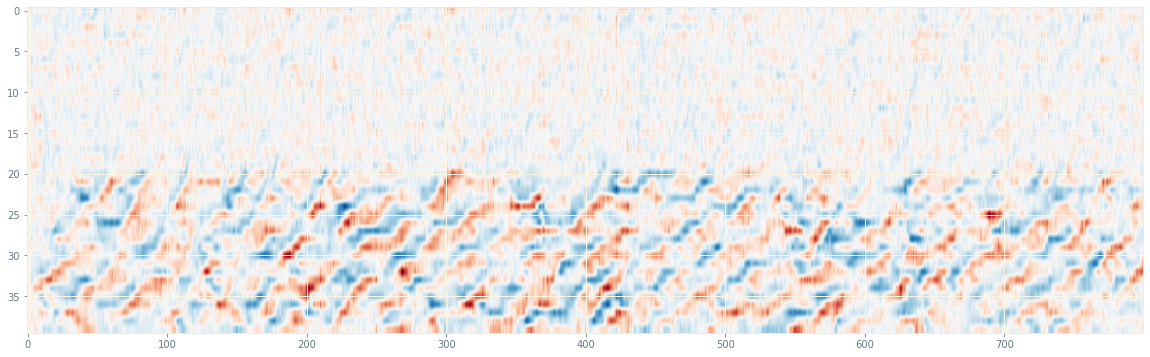

In [10]:
analysis_error = truth.state_vector[:, 1001::period_assim] - xabar.T
mi, ma = analysis_error.min(), analysis_error.max()
lim = max(np.abs(mi), np.abs(ma))
plt.figure(figsize=(20, 6))
plt.imshow(analysis_error, vmin=-lim, vmax=lim, cmap='RdBu', aspect='auto')

In [11]:
analysis_error = xabar[:, 0] - truth.state_vector[0, (1000+period_assim)::period_assim]
observation_error = obs[:, 0] - truth.state_vector[0, (1000+period_assim)::period_assim]
ea = ((analysis_error)**2).mean()
eo = ((observation_error)**2).mean()
print(f"{'Analysis error:': >20} {ea:>20}")
print(f"{'Observation error:': >20} {eo:>20}")

     Analysis error:   3.3934812294480547
  Observation error:    9.171483080712564
